#import


In [ ]:
import numpy as np
import time
import matplotlib.pyplot as plt
import random 
import copy
from torchvision.datasets import VisionDataset, CIFAR100
from torchvision import transforms
from torch.utils.data import Subset,DataLoader
import torch
from torch import nn 
from torch.nn import BCEWithLogitsLoss    
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
from torch.backends.cudnn import benchmark
import torch.nn.functional as F
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cosine
import torch.optim as optim
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#dataset

In [ ]:
np.random.seed(1993) 
order = np.arange(100)
np.random.shuffle(order)
print(order)
class Cifar100(VisionDataset):
    def __init__(self, root, train,order=order, transform=None, target_transform=None):
        super(Cifar100, self).__init__(root, transform=transform, target_transform=target_transform)
        self.dataset = CIFAR100(root=root, train=train, download=True, transform=transform)
        self.order=order
        self.label_map = {k: v for v, k in enumerate(self.order)}
        self.lala=[self.order[x:x+10] for x in range(0, len(self.order), 10)]
        dictionary={}
        for i,(_,el) in enumerate(self.dataset):
          dictionary.setdefault(el,[]).append(i)
        self.dictionary=dictionary
    def __getitem__(self, index):
        image, label = self.dataset[index]
        return index,image,self.label_map[label]

    def set_indici(self,set_t):
      temp=[]
      for el in set_t:
        temp+=self.dictionary[el]
      return temp

    def __len__(self):
        return len(self.dataset)



[68 56 78  8 23 84 90 65 74 76 40 89  3 92 55  9 26 80 43 38 58 70 77  1
 85 19 17 50 28 53 13 81 45 82  6 59 83 16 15 44 91 41 72 60 79 52 20 10
 31 54 37 95 14 71 96 98 97  2 64 66 42 22 35 86 24 34 87 21 99  0 88 27
 18 94 11 12 47 25 30 46 62 69 36 61  7 63 75  5 32  4 51 48 73 93 39 67
 29 49 57 33]


In [ ]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5071,  0.4866,  0.4409), (0.2009,  0.1984,  0.2023)),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071,  0.4866,  0.4409), (0.2009,  0.1984,  0.2023)),
])
train_data=Cifar100('./',order=order,train=True,transform=train_transform)
test_data=Cifar100('./',order=order,train=False,transform=test_transform)


Extracting ./cifar-100-python.tar.gz to ./
Files already downloaded and verified


#resnet

In [ ]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes):
        self.old_model = None
        self.num_classes = num_classes
        self.inplanes = 16
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0])
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8, stride=1)
        self.fc = nn.Linear(64 * block.expansion, self.num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x, features=False):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        
        if features:
            x = x / x.norm()
        else:
            x = self.fc(x)

        return x

def resnet20(pretrained=False, **kwargs):
    n = 3
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet32(pretrained=False, **kwargs):
    n = 5
    model = ResNet(BasicBlock, [n, n, n], **kwargs)
    return model

def resnet56(pretrained=False, **kwargs):
    n = 9
    model = ResNet(Bottleneck, [n, n, n], **kwargs)
    return model

#LWF

In [ ]:
def cod_one_hot(x,classes):
  y_one_hot = torch.zeros(len(x), classes).to('cuda')
  y_one_hot = y_one_hot.scatter(1,x.long().view(-1,1),1)
  return y_one_hot

class LWF():
    def __init__(self,epoch=3,lr=2):
      super(LWF, self).__init__()
      self.device = 'cuda'
      self.n_classes=10
      self.model=resnet32(num_classes=self.n_classes)
      self.lr=lr
      self.momentum=0.9
      self.epoch=epoch
      self.weight_decay=0.00001

    def update_model(self):
      f_in = self.model.fc.in_features
      f_out = self.model.fc.out_features
      weight = self.model.fc.weight.data
      bias = self.model.fc.bias.data
      self.model.fc = nn.Linear(f_in, self.n_classes)
      self.model.fc.weight.data[:f_out] = weight
      self.model.fc.bias.data[:f_out] = bias

    def update(self,dataloader,l):
        criterion = BCEWithLogitsLoss()
        if self.n_classes != 10:        
          self.model.eval()
          old_out = torch.zeros(50000, self.n_classes-10).to(self.device)
          with torch.no_grad():
            for indexes, images,_ in dataloader:
              images = images.to(self.device)
              indexes = indexes.to(self.device)
              g_y = torch.sigmoid(self.model(images))
              old_out[indexes] = g_y
            old_out = old_out.to(self.device)
          self.update_model()
          
        optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        self.model = self.model.to(self.device)
        
        for epoch in range(self.epoch):
          if (epoch+1) == 49 or (epoch+1) == 63:
            for j in optimizer.param_groups:
              j['lr'] = j['lr']/5
          self.model.train() 
          for indexes,  images,labels in dataloader:
            indexes = indexes.to(self.device)              
            images = images.to(self.device)
            labels = labels.to(self.device)
            optimizer.zero_grad()

            outputs = self.model(images)      

            classes=self.n_classes
            labels = cod_one_hot(labels,classes)
            
            if self.n_classes == 10:
              loss=criterion(outputs[:,self.n_classes-10:], labels[:,self.n_classes-10:])
            else:
              loss = criterion(outputs,torch.cat((old_out[indexes],labels[:,self.n_classes-10:]),1))     
                     
            loss.backward() 
            optimizer.step() 

          print(f"\r EPOCH:{epoch+1} on {self.epoch} , loss:{loss},LR:{optimizer.param_groups[0]['lr']}",end='')
        self.n_classes+=10

#JOINT TRAINING

In [ ]:
def eval(dataloader,net,length):
  pred_t=[]
  label_t=[]
  net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda
  net.train(False) # Set Network to evaluation mode
  running_corrects = 0
  for _,images, labels in dataloader:
    images = images.to(DEVICE)
    labels = labels.to(DEVICE)
    # Forward Pass
    outputs = net(images)
    # Get predictions
    _, preds = torch.max(outputs.data, 1)
    # Update Corrects
    pred_t+=list(preds.cpu().numpy())
    label_t+=list(labels.data.cpu().numpy())
    running_corrects += torch.sum(preds == labels.data).data.item()
  p,r,f1,s=precision_recall_fscore_support(pred_t,label_t)
  conf_mat = confusion_matrix(label_t,pred_t)
  # Calculate Accuracy
  accuracy = running_corrects / float(length)
  return accuracy,conf_mat

In [ ]:
!nvidia-smi

Fri Jun 26 10:52:06 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
def train_eval(train_dataloader,val_dataloader,length,net,criterion,NUM_EPOCHS,optimizer,scheduler):
  net = net.to(DEVICE) 
  net = nn.DataParallel(net)
  new_accuracy=0
  accuracy_list=[]
  loss_list=[]
  current_step = 0
  for epoch in range(NUM_EPOCHS):
    for _,images, labels in train_dataloader:
      images = images.to(DEVICE)
      labels = labels.to(DEVICE)
      net.train() 
      optimizer.zero_grad()
      outputs = net(images)
      loss = criterion(outputs, labels)
      loss_list.append(loss.item())
      loss.backward()  # backward pass: computes gradients
      optimizer.step() # update weights based on accumulated gradients
      current_step += 1
    accuracy,conf_mat=eval(val_dataloader,net,length)  # EVALUATION AT THE i-th EPOCH
    print(f'\rEpoch {epoch+1}/{NUM_EPOCHS}, LR = {scheduler.get_last_lr()},accuracy = {accuracy}', end='')
    accuracy_list.append(accuracy)     #KEEP TRACE OF THE ACCURACY
    scheduler.step() 
  plt.plot(range(1,NUM_EPOCHS+1),accuracy_list)
  plt.xlabel("Number of epoch")
  plt.ylabel("Accuracy")
  plt.title("CNN: Accuracy vs Number of epochs")
  plt.show()
  plt.plot(range(0,len(loss_list)),loss_list)
  plt.xlabel("Number of step")
  plt.ylabel("loss")
  plt.title("CNN: Loss vs Steps")
  plt.show()
  return accuracy,conf_mat

In [ ]:
train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=4, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=4)

In [ ]:
DEVICE='cuda'
net=resnet32(num_classes=100)
criterion = nn.CrossEntropyLoss()
parameters_to_optimize = net.parameters()
optimizer = optim.SGD(parameters_to_optimize, lr=0.02, momentum=0.9, weight_decay=0.0005)
scheduler = optim.lr_scheduler.StepLR(optimizer,gamma=0.1,step_size=20)
acc,conf=train_eval(train_dataloader,test_dataloader,len(test_data),net,criterion,70,optimizer,scheduler)

#MAIN FINETUNING

set of classes:[68 56 78  8 23 84 90 65 74 76]
length training set:5000
lunghezza test:1000
batch:1
Epoch 1/70, LR = [0.2],accuracy = 0.151

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 70/70, LR = [0.008000000000000002],accuracy = 0.857

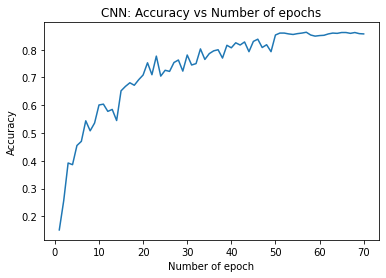

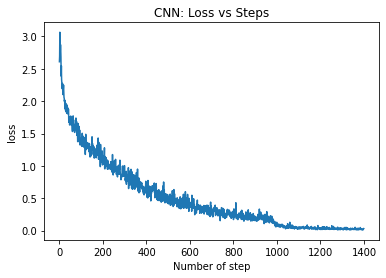

set of classes:[40 89  3 92 55  9 26 80 43 38]
length training set:5000
lunghezza test:2000
batch:2
Epoch 70/70, LR = [0.008000000000000002],accuracy = 0.389

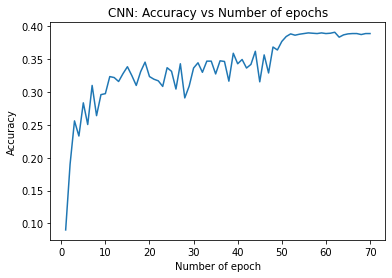

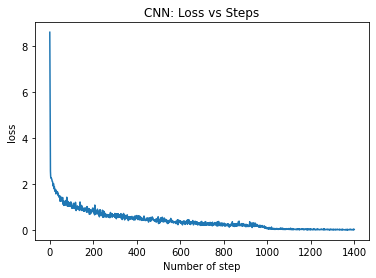

set of classes:[58 70 77  1 85 19 17 50 28 53]
length training set:5000
lunghezza test:3000
batch:3
Epoch 70/70, LR = [0.008000000000000002],accuracy = 0.29633333333333334

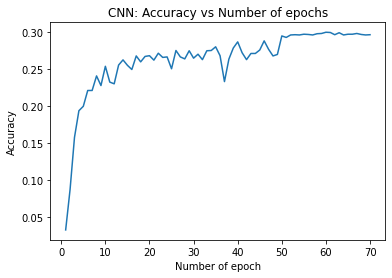

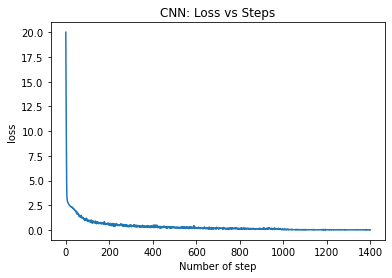

set of classes:[13 81 45 82  6 59 83 16 15 44]
length training set:5000
lunghezza test:4000
batch:4
Epoch 70/70, LR = [0.008000000000000002],accuracy = 0.204

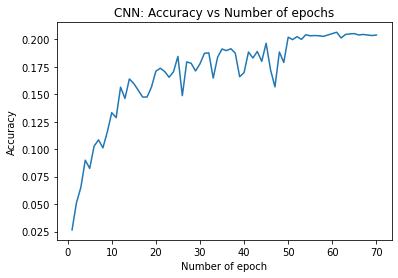

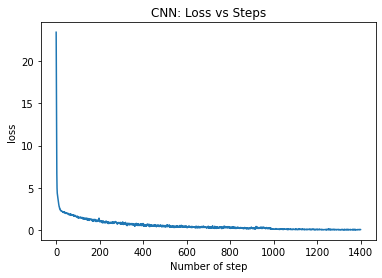

set of classes:[91 41 72 60 79 52 20 10 31 54]
length training set:5000
lunghezza test:5000
batch:5
Epoch 70/70, LR = [0.008000000000000002],accuracy = 0.1798

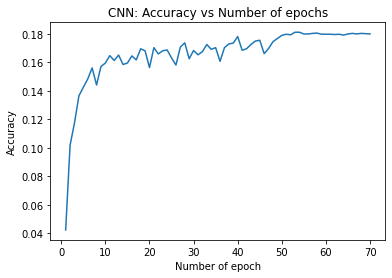

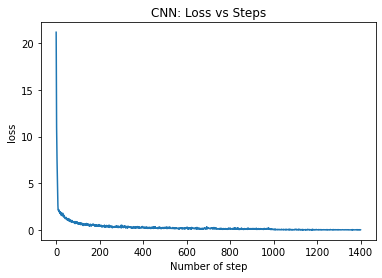

set of classes:[37 95 14 71 96 98 97  2 64 66]
length training set:5000
lunghezza test:6000
batch:6
Epoch 70/70, LR = [0.008000000000000002],accuracy = 0.13616666666666666

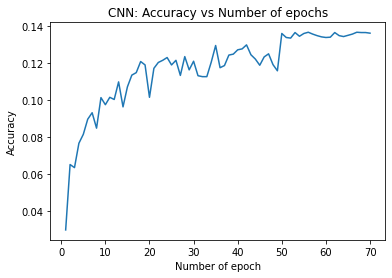

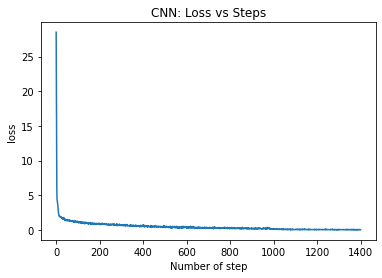

set of classes:[42 22 35 86 24 34 87 21 99  0]
length training set:5000
lunghezza test:7000
batch:7
Epoch 70/70, LR = [0.008000000000000002],accuracy = 0.12271428571428572

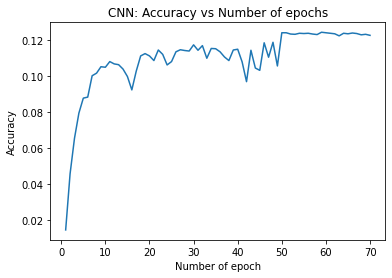

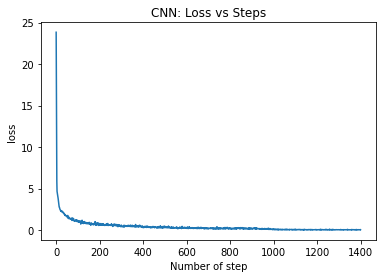

set of classes:[88 27 18 94 11 12 47 25 30 46]
length training set:5000
lunghezza test:8000
batch:8
Epoch 70/70, LR = [0.008000000000000002],accuracy = 0.103

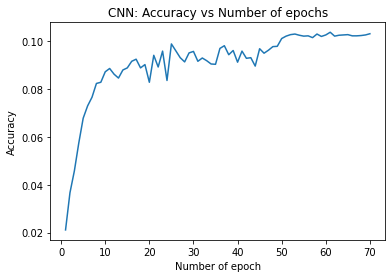

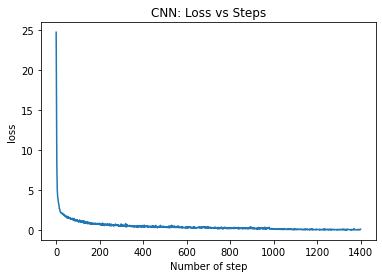

set of classes:[62 69 36 61  7 63 75  5 32  4]
length training set:5000
lunghezza test:9000
batch:9
Epoch 70/70, LR = [0.008000000000000002],accuracy = 0.09

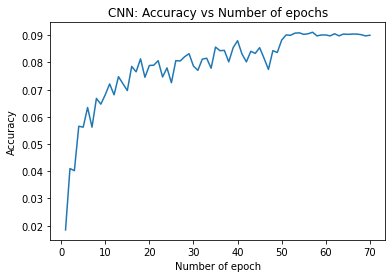

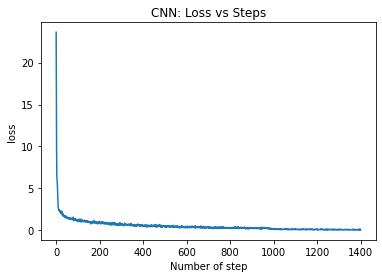

set of classes:[51 48 73 93 39 67 29 49 57 33]
length training set:5000
lunghezza test:10000
batch:10
Epoch 70/70, LR = [0.008000000000000002],accuracy = 0.0779

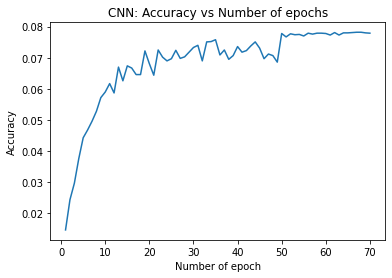

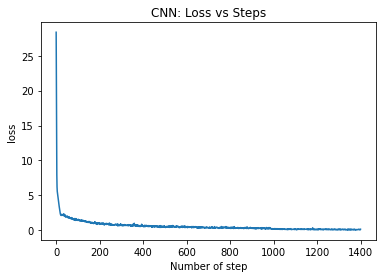

In [ ]:
previous_ind=[]
acc_list = []
b=1
DEVICE='cuda'
net=resnet32(num_classes=10)
for i in train_data.lala:
  classes=b*10
  train_ind=train_data.set_indici(i)  
  train=Subset(train_data,train_ind)
  train_loader=DataLoader(train, batch_size=256, shuffle=True, num_workers=4)
  test_ind=test_data.set_indici(i)
  previous_ind+=test_ind
  test=Subset(test_data,previous_ind)
  test_loader=DataLoader(test, batch_size=256, shuffle=False, num_workers=4)
  print(f'set of classes:{i}\nlength training set:{len(train)}\nlunghezza test:{len(test)}\nbatch:{b}')
  f_in = net.fc.in_features
  f_out = net.fc.out_features
  weight = net.fc.weight.data
  bias = net.fc.bias.data
  net.fc = nn.Linear(f_in, classes)
  net.fc.weight.data[:f_out] = weight
  net.fc.bias.data[:f_out] = bias
  criterion = nn.CrossEntropyLoss()
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=0.2, momentum=0.9, weight_decay=0.00001 )
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=[49,63],gamma=0.2)
  acc,d=train_eval(train_loader,test_loader,len(test),net,criterion,70,optimizer,scheduler)
  acc_list.append(acc)
  b+=1

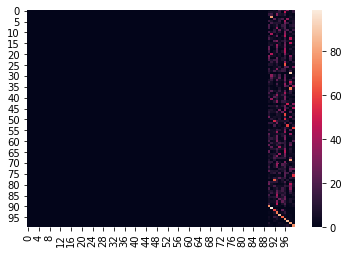

In [ ]:
fig, ax = plt.subplots()
ax = sns.heatmap(d)
plt.show()

#MAIN LEARNING WITHOUT FORGETTING

In [ ]:
model = LWF(epoch=70,lr=2)
previous_ind=[]
acc_list = []
b=1
for i in train_data.lala:
  train_ind=train_data.set_indici(i)
  train=Subset(train_data,train_ind)
  train_loader=DataLoader(train, batch_size=256, shuffle=True, num_workers=4)
  test_ind=test_data.set_indici(i)
  previous_ind+=test_ind
  test=Subset(test_data,previous_ind)
  test_loader=DataLoader(test, batch_size=256, shuffle=False, num_workers=4)
  n_classes=model.n_classes
  print(f'set of classes:{i}\nlength training set:{len(train)}\nlunghezza test:{len(test)}\nnumber of classes:{n_classes}\nbatch:{b}')
  model.update(train_loader,len(train))
  acc=eval(test_loader,model.model,len(test))
  acc_list.append(acc)
  b+=1

set of classes:[68 56 78  8 23 84 90 65 74 76]
length training set:5000
lunghezza test:1000
number of classes:10
batch:1
 EPOCH:70 on 70 , loss:0.08697739243507385,LR:0.08set of classes:[40 89  3 92 55  9 26 80 43 38]
length training set:5000
lunghezza test:2000
number of classes:20
batch:2
 EPOCH:70 on 70 , loss:0.12643444538116455,LR:0.08set of classes:[58 70 77  1 85 19 17 50 28 53]
length training set:5000
lunghezza test:3000
number of classes:30
batch:3


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 EPOCH:70 on 70 , loss:0.12225324660539627,LR:0.08set of classes:[13 81 45 82  6 59 83 16 15 44]
length training set:5000
lunghezza test:4000
number of classes:40
batch:4
 EPOCH:70 on 70 , loss:0.12999451160430908,LR:0.08set of classes:[91 41 72 60 79 52 20 10 31 54]
length training set:5000
lunghezza test:5000
number of classes:50
batch:5
 EPOCH:70 on 70 , loss:0.13657023012638092,LR:0.08set of classes:[37 95 14 71 96 98 97  2 64 66]
length training set:5000
lunghezza test:6000
number of classes:60
batch:6
 EPOCH:70 on 70 , loss:0.1445554941892624,LR:0.08set of classes:[42 22 35 86 24 34 87 21 99  0]
length training set:5000
lunghezza test:7000
number of classes:70
batch:7
 EPOCH:70 on 70 , loss:0.15352559089660645,LR:0.08set of classes:[88 27 18 94 11 12 47 25 30 46]
length training set:5000
lunghezza test:8000
number of classes:80
batch:8
 EPOCH:70 on 70 , loss:0.15681087970733643,LR:0.08set of classes:[62 69 36 61  7 63 75  5 32  4]
length training set:5000
lunghezza test:9000
numb